In [1]:
using NeuralPDE, Optimization, OptimizationOptimJL, Roots,
      LineSearches
using ModelingToolkit, IntervalSets 
using IntervalSets
using Plots, Printf
using Lux, LuxCUDA, ComponentArrays, Random
using JLD2, LinearAlgebra 

In [2]:
@parameters t, x, y
@variables B1(..), B2(..)
Dx = Differential(x)
Dy = Differential(y)
Dt = Differential(t)



Differential(t)

In [8]:
@load "toy_MHD_2D.jld2" config domains eqs bcs depvars loss minimizers_ #phi_d loss


7-element Vector{Symbol}:
 :config
 :domains
 :eqs
 :bcs
 :depvars
 :loss
 :minimizers_

In [11]:
# Neural network
input_ = length(domains)
n = config[:N_neurons]
chain = [Chain(Dense(input_, n, σ), Dense(n, n, σ), Dense(n, 1)) for _ in 1:2]

#strategy = QuadratureTraining()
#strategy = QuasiRandomTraining(100)
strategy = GridTraining(config[:dx])
#ps = Lux.setup(Random.default_rng(), chain)[1] 
#ps = ps |> ComponentArray |> gpud
discretization = PhysicsInformedNN(chain, strategy) #; init_params = ps)
phi_d = discretization.phi

2-element Vector{NeuralPDE.Phi{StatefulLuxLayer{Val{true}, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}}:
 NeuralPDE.Phi{StatefulLuxLayer{Val{true}, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}(StatefulLuxLayer{Val{true}, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Den

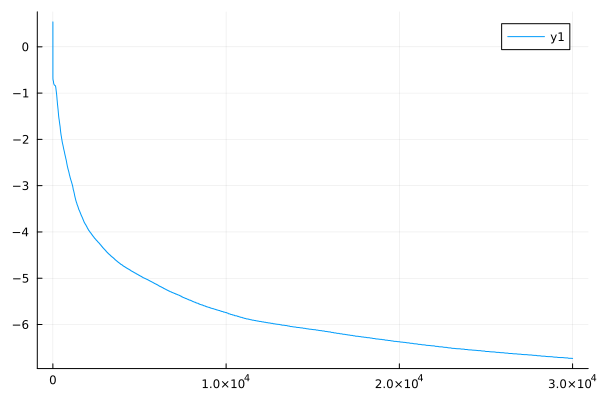

In [7]:
plot(log10.(loss))

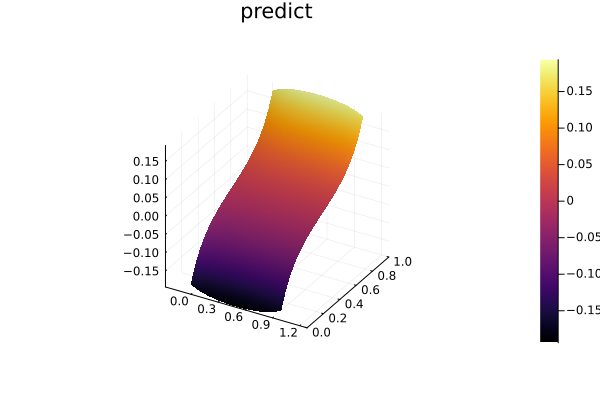

In [12]:
xs, ys = [0.0:0.01:1.0 for d in 1:2]
#depvars = [:B1, :B2]
#minimizers_ = [res.u.depvar[depvars[i]] for i in 1:length(chain)]

t_p = 0.5
 #config[:tmax]
u_predict = [[phi_d[i]([t_p, x, y], minimizers_[i])[1] for x in xs for y in ys] for i in 1:2]

ps = []
for i in 1:2
    p1 = plot(xs, ys, u_predict[:,:][i], 
        #linetype = :contourf, 
        st = :surface,
        title = "predict", aspect_ratio = 1)
    push!(ps, p1)
end

plot(ps[2])#, ps[2], layout = (1,2))

┌ Info: Animating frame 1...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sdnNjb2RlLXJlbW90ZQ==.jl:4
┌ Info: Animating frame 2...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sdnNjb2RlLXJlbW90ZQ==.jl:4
┌ Info: Animating frame 3...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sdnNjb2RlLXJlbW90ZQ==.jl:4
┌ Info: Animating frame 4...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sdnNjb2RlLXJlbW90ZQ==.jl:4
┌ Info: Animating frame 5...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sdnNjb2RlLXJlbW90ZQ==.jl:4
┌ Info: Animating frame 6...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sdnNjb2RlLXJlbW90ZQ==.jl:4
┌ Info: Animating frame 7...
└ @ Main /users/oreula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sdnNjb2RlLXJlbW90ZQ==.jl:4
┌ Info

Plots.AnimatedGif("/users/oreula/Julia/PINN/Toy_MHD_pde.gif")
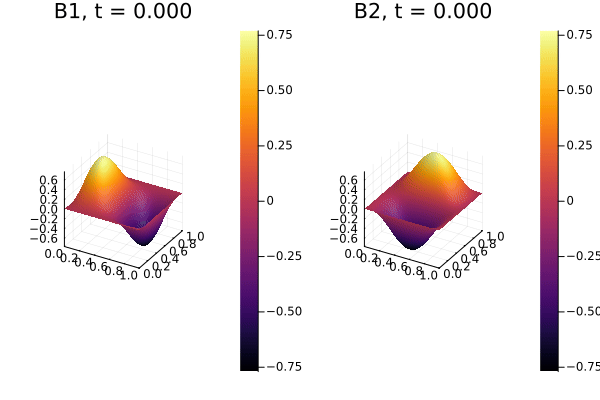

In [13]:
function plot_(phi_d, minimizers_)
    # Animate
    anim = @animate for (i, t_p) in enumerate(0:0.05:config[:tmax])
        @info "Animating frame $i..."
        B1_approx = [phi_d[1]([t_p, x, y], minimizers_[1])[1] for x in xs for y in ys]
        B2_approx = [phi_d[2]([t_p, x, y], minimizers_[2])[1] for x in xs for y in ys]
        title = @sprintf("B1, t = %.3f", t_p)
        p1 = plot(xs, ys, B1_approx, st = :surface, label = "B1", title = title)
        title = @sprintf("B2, t = %.3f", t_p)
        p2 = plot(xs, ys, B2_approx, st = :surface, label = "B2", title = title)
        plot(p1, p2)
    end
    gif(anim, "Toy_MHD_pde.gif", fps = 10)
end

plot_(phi_d, minimizers_)